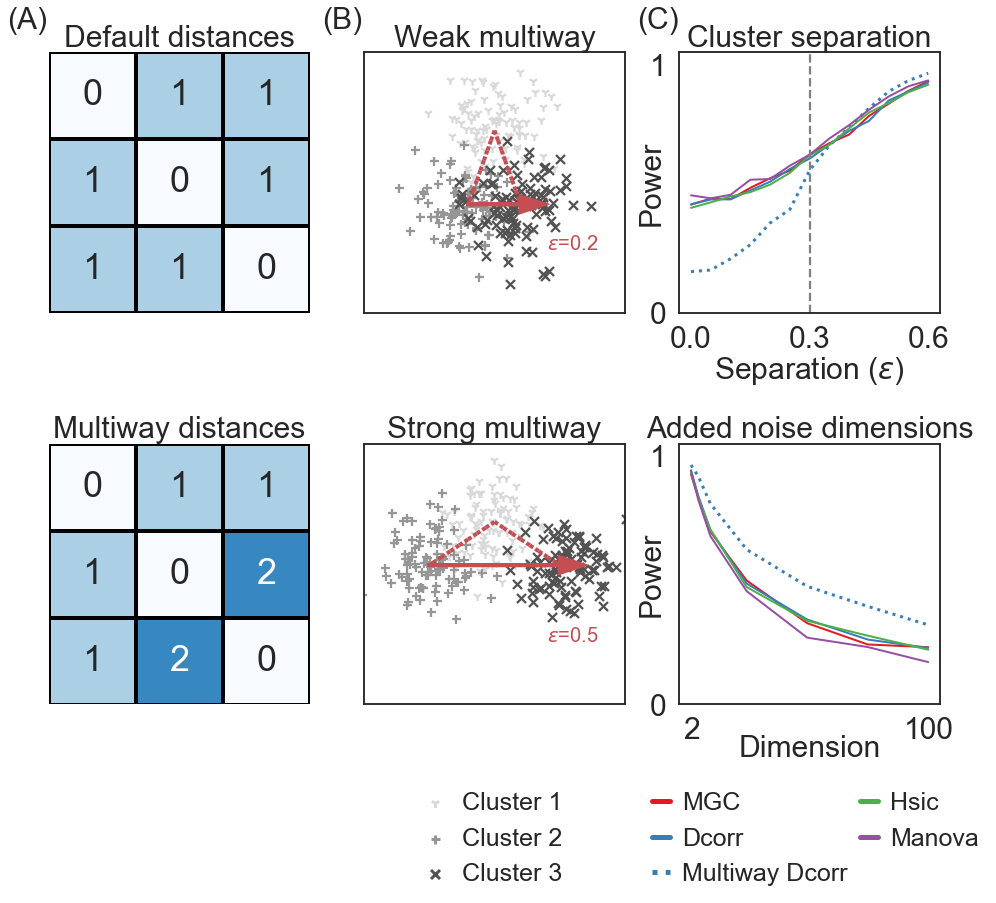

In [72]:
#!/usr/bin/env python
# coding: utf-8

# # 3 Sample Tests Power over Increasing Dimension

# These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

# In[1]:


import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from hyppo.independence import MGC, Dcorr, Hsic
from hyppo.sims import gaussian_3samp
from joblib import Parallel, delayed
from matplotlib.legend import Legend

from power_3samp import power_3samp_epsweight

sys.path.append(os.path.realpath(".."))


# In[4]:


import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])


# In[6]:


from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """

    def __init__(self):
        self.stats = importr("stats")
        self.r_base = importr("base")

        numpy2ri.activate()

        self.formula = Formula("X ~ Y")
        self.env = self.formula.environment

    def statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env["Y"] = y
        self.env["X"] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat


# In[7]:

NAME = "3samp-multiway"
MAX_EPSILONS1 = 0.6
STEP_SIZE = 0.05
EPSILONS = np.arange(0, MAX_EPSILONS1 + STEP_SIZE, STEP_SIZE)
EPSILON1 = 0.5
EPSILONS2 = [None]
DIMENSIONS = [2, 5, 10, 25, 50, 75, 100]
POWER_REPS = 5
REPS = 1000
n_jobs = 45
workers = 45
ONEWAY_EPSILON = 0.3

# FONTSIZE = 12

tests = [
    MGC,
    Dcorr,
    Hsic,
    Manova,
]

multiway_tests = [
    Dcorr,
]

multiway_cases = [
    6,
]

# The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

# In[9]:

FONTSIZE = 30


def plot_power():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

    sim_title = [
        ["Default distances", "Multiway distances"],
        ["Weak multiway", "Strong multiway"],
        ["Cluster separation", "Added noise dimensions"],
    ]
    sim_markers = ["1", "+", "x"]
    custom_color = ["#d9d9d9", "#969696", "#525252"]

    # Label matrices
    col = 0
    oneway = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
    twoway = [[0, 1, 1], [1, 0, 2], [1, 2, 0]]
    for i, way in enumerate([oneway, twoway]):
        ax = axes[i][col]
        sns.heatmap(
            way,
            annot=True,
            fmt="d",
            ax=ax,
            cbar=False,
            vmin=0,
            vmax=3,
            cmap="Blues",
            linewidth=3,
            linecolor="black",
        )
        ax.set_xticks([])
        # ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=16)
        ax.set_yticks([])
        # ax.set_yticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'], rotation=90, fontsize=16, va='center')
        ax.set_title(sim_title[col][i], fontsize=FONTSIZE)
        ax.set_aspect("equal")

    # Simulated data
    col = 1
    SCALE = 10
    np.random.seed(0)
    for i, epsilon in enumerate([0.2, 0.5]):
        ax = axes[i][col]
        sims = gaussian_3samp(
            100, epsilon=epsilon * SCALE, case=6, c=ONEWAY_EPSILON * SCALE
        )

        scatters = []
        for count, sim in enumerate(sims):
            x, y = np.hsplit(sim, 2)
            scatters.append(
                ax.scatter(x, y, marker=sim_markers[count], color=custom_color[count])
            )

        ax.set_xlim(-5, 5)
        ax.set_ylim(-7, 3)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(sim_title[col][i], fontsize=FONTSIZE)
        ax.text(
            3,
            -4,
            r"$\varepsilon$" + f"={epsilon:.1f}",
            size=20,
            va="top",
            ha="center",
            color="r",
        )
        a = np.sqrt(ONEWAY_EPSILON ** 2 - (epsilon / 2) ** 2) * SCALE
        epsilon = epsilon * SCALE
        ax.arrow(
            -epsilon / 2,
            -a,
            epsilon,
            0,
            ec="r",
            fc="r",
            alpha=1,
            head_width=0.6,
            lw=4,
            ls="-",
        )
        ax.arrow(
            0, 0, -epsilon / 2, -a, ec="r", fc="r", alpha=1, head_width=0, ls=":", lw=4
        )
        ax.arrow(
            0, 0, epsilon / 2, -a, ec="r", fc="r", alpha=1, head_width=0, ls=":", lw=4
        )
        # ax.text(-2, -1, f'c={ONEWAY_EPSILON}', size=20, va='bottom', ha='center', color='r')
        ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))
    
    # Power curves
    col = 2
    custom_color = {
        "Dcorr": "#377eb8",
        "Hsic": "#4daf4a",
        "MGC": "#e41a1c",
    }
    for i, name in enumerate(["3samp_vs_epsilon", "3samp_vs_dim"]):
        ax = axes[i][col]
        if i == 0:
            XRANGE = EPSILONS
        elif i == 1:
            XRANGE = DIMENSIONS
        for test in tests:
            for multiway in [False, True]:
                if (multiway and test not in multiway_tests) or (
                    not multiway and test not in tests
                ):
                    continue
                elif multiway:
                    power = np.genfromtxt(
                        "../ksample/{}/{}_{}_multiway.csv".format(
                            name, 6, test.__name__
                        ),
                        delimiter=",",
                    )
                    ls = "dotted"
                    lw = 3
                    label = f"Multiway {test.__name__}"
                else:
                    power = np.genfromtxt(
                        "../ksample/{}/{}_{}.csv".format(name, 6, test.__name__),
                        delimiter=",",
                    )
                    ls = "-"
                    lw = 2
                    label = test.__name__
                if test.__name__ in custom_color.keys():
                    ax.plot(
                        XRANGE,
                        power,
                        custom_color[test.__name__],
                        label=label,
                        lw=lw,
                        ls=ls,
                    )
                else:
                    ax.plot(XRANGE, power, label=label, lw=lw, ls=ls)
                ax.tick_params(labelsize=FONTSIZE)

                if i == 0:
                    ax.set_xticks([XRANGE[0], ONEWAY_EPSILON, XRANGE[-1]])
                elif i == 1:
                    ax.set_xticks([XRANGE[0], XRANGE[-1]])
                    ax.set_xticklabels([XRANGE[0], XRANGE[-1]])
                ax.set_ylim(0, 1.05)
                ax.set_yticks([0, 1])
        if i == 0:
            ax.axvline(ONEWAY_EPSILON, ls="--", c="grey")
        ax.set_title(sim_title[col][i], fontsize=FONTSIZE)
        ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))

    fig.text(
        0.5,
        -0.25,
        r"Separation ($\varepsilon$)",
        ha="center",
        fontsize=FONTSIZE,
        transform=axes[0][2].transAxes,
    )
    fig.text(
        0.5,
        -0.2,
        "Dimension",
        ha="center",
        fontsize=FONTSIZE,
        transform=axes[1][2].transAxes,
    )
    # fig.text(-0.12, 0.5, 'Power', va='center', rotation='vertical', fontsize=FONTSIZE, transform=axes[2][0].transAxes)

#     fig.text(
#         -0.16,
#         0.5,
#         "Label matrices",
#         va="center",
#         rotation="vertical",
#         fontsize=FONTSIZE,
#         transform=axes[0][0].transAxes,
#     )
#     fig.text(
#         -0.16,
#         0.5,
#         "Scatter plots",
#         va="center",
#         rotation="vertical",
#         fontsize=FONTSIZE,
#         transform=axes[0][1].transAxes,
#     )
    fig.text(
        -0.16,
        0.5,
        "Power",
        va="center",
        rotation="vertical",
        fontsize=FONTSIZE,
        transform=axes[0][2].transAxes,
    )
    fig.text(
        -0.16,
        -1.0,
        "Power",
        va="center",
        rotation="vertical",
        fontsize=FONTSIZE,
        transform=axes[0][2].transAxes,
    )
    # fig.text(-0.10, 0.5, 'Power', va='center', rotation='vertical', fontsize=FONTSIZE, transform=axes[2][0].transAxes)
    fig.text(
        -0.16,
        1.12,
        "(A)",
        va="center",
        fontsize=FONTSIZE,
        transform=axes[0][0].transAxes,
    )
    fig.text(
        -0.16,
        1.12,
        "(B)",
        va="center",
        fontsize=FONTSIZE,
        transform=axes[0][1].transAxes,
    )
    fig.text(
        -0.16,
        1.12,
        "(C)",
        va="center",
        fontsize=FONTSIZE,
        transform=axes[0][2].transAxes,
    )
    leg = plt.legend(
        bbox_to_anchor=(0.63, 0.05),
        bbox_transform=plt.gcf().transFigure,
        ncol=2,
        loc="upper left",
        fontsize=FONTSIZE-5,
        handletextpad=0.5,
        columnspacing=0.5,
        handlelength=0.7,
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    leg = Legend(
        fig,
        scatters,
        ["Cluster 1", "Cluster 2", "Cluster 3"],
        loc="upper left",
        frameon=False,
        ncol=1,
        bbox_transform=plt.gcf().transFigure,
        bbox_to_anchor=(0.42, 0.05),
        fontsize=FONTSIZE-5,
        handletextpad=0.05,
        columnspacing=0.5,
    )
    fig.add_artist(leg)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    plt.savefig(f"../ksample/figs/{NAME}.pdf", transparent=True, bbox_inches="tight")


plot_power()


# %%

# %%
